# Incidence de la grippe

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

Les données de l'incidence de la varicelle proviennent du site Web du Réseau Sentinelles. Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1990 et se termine avec une semaine récente.

In [2]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv" 

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant skiprows=1.

In [3]:
raw_data = pd.read_csv(data_url, skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202012          7   7929     5566   10292      12           8   
1     202011          7  10198     7568   12828      15          11   
2     202010          7   9011     6691   11331      14          10   
3     202009          7  13631    10544   16718      21          16   
4     202008          7  10424     7708   13140      16          12   
5     202007          7   8959     6574   11344      14          10   
6     202006          7   9264     6925   11603      14          10   
7     202005          7   8505     6314   10696      13          10   
8     202004          7   7991     5831   10151      12           9   
9     202003          7   5968     4100    7836       9           6   
10    202002          7   6534     4530    8538      10           7   
11    202001          7   9835     7019   12651      15          11   
12    201952          7   7941     5246   10636      12           8   
13    201951          7   5823     3675    7971       9           6   
14    201950          7   6424     4276    8572      10           7   
15    201949          7   6621     4540    8702      10           7   
16    201948          7   5542     3383    7701       8           5   
17    201947          7   7536     5058   10014      11           7   
18    201946          7   2638     1316    3960       4           2   
19    201945          7   4492     2615    6369       7           4   
20    201944          7   5728     3627    7829       9           6   
21    201943          7   4834     2751    6917       7           4   
22    201942          7   6279     3989    8569      10           7   
23    201941          7   4130     2030    6230       6           3   
24    201940          7   4211     2218    6204       6           3   
25    201939          7   3137     1310    4964       5           2   
26    201938          7   3078     1416    4740       5           2   
27    201937          7    970      162    1778       1           0   
28    201936          7   1277      263    2291       2           0   
29    201935          7    922        0    1857       1           0   
...      ...        ...    ...      ...     ...     ...         ...   
1499  199126          7  17608    11304   23912      31          20   
1500  199125          7  16169    10700   21638      28          18   
1501  199124          7  16171    10071   22271      28          17   
1502  199123          7  11947     7671   16223      21          13   
1503  199122          7  15452     9953   20951      27          17   
1504  199121          7  14903     8975   20831      26          16   
1505  199120          7  19053    12742   25364      34          23   
1506  199119          7  16739    11246   22232      29          19   
1507  199118          7  21385    13882   28888      38          25   
1508  199117          7  13462     8877   18047      24          16   
1509  199116          7  14857    10068   19646      26          18   
1510  199115          7  13975     9781   18169      25          18   
1511  199114          7  12265     7684   16846      22          14   
1512  199113          7   9567     6041   13093      17          11   
1513  199112          7  10864     7331   14397      19          13   
1514  199111          7  15574    11184   19964      27          19   
1515  199110          7  16643    11372   21914      29          20   
1516  199109          7  13741     8780   18702      24          15   
1517  199108          7  13289     8813   17765      23          15   
1518  199107          7  12337     8077   16597      22          15   
1519  199106          7  10877     7013   14741      19          12   
1520  199105          7  10442     6544   14340      18          11   
1521  199104          7   7913     4563   11263      14           8   
1522  199103          7  15387    10484   20290      27          18   
1523  199102          7  16277  

Y a-t-il des points manquants dans ce jeux de données ? Non.

In [4]:
raw_data[raw_data.isnull().any(axis=1)]
data = raw_data

Nos données utilisent une convention inhabituelle: le numéro de semaine est collé à l'année, donnant l'impression qu'il s'agit de nombre entier. C'est comme ça que Pandas les interprète.

Un deuxième problème est que Pandas ne comprend pas les numéros de semaine.  Il faut lui fournir les dates de début et de fin de semaine. Nous utilisons pour cela la bibliothèque isoweek.

Comme la conversion des semaines est devenu assez complexe, nous écrivons une petite fonction Python pour cela. Ensuite, nous l'appliquons à tous les points de nos donnés. Les résultats vont dans une nouvelle colonne 'period'.

In [5]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']] 

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans le sens chronologique.

In [6]:
sorted_data = data.set_index('period').sort_index() 

Nous vérifions la cohérence des données. Entre la fin d'une période et le début de la période qui suit, la différence temporelle doit être zéro, ou au moins très faible. Nous laissons une "marge d'erreur" d'une seconde.

Ceci s'avère tout à fait juste.

In [7]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Un premier regard sur les données !

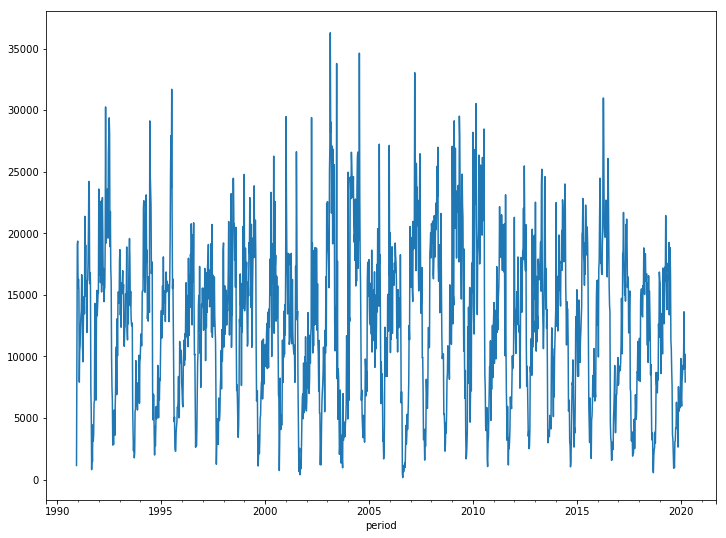

In [8]:
plt.figure(figsize=(12,9))
sorted_data['inc'].plot()

Un zoom sur les dernières années montre mieux la situation des pics en hiver. Le creux des incidences se trouve en septembre.

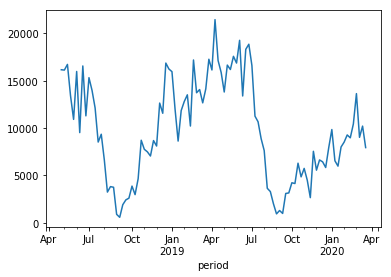

In [9]:
sorted_data['inc'][-100:].plot() 

# Etude de l'incidence annuelle


Nous définissons la période de référence entre deux minima de l'incidence, du 1er septembre de l'année N au
1er septembre de l'année N+1.

Notre tâche est un peu compliquée par le fait que l'année ne comporte pas un nombre entier de semaines. Nous modifions donc un peu nos périodes de référence: à la place du 1er septembre de chaque année, nous utilisons le premier jour de la semaine qui contient le 1er septembre.

Comme l'incidence de la varicelle est très faible en septembre, cette modification ne devrait pas fausser nos conclusions.

Encore un petit détail: les données commencent an décembre 1990, ce qui rend la première année incomplète. Nous commençons donc l'analyse en 1991.

In [10]:
first_sep_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)] 

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [11]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_sep_week[:-1],
                        first_sep_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    if not abs(len(one_year)-52) < 2 :
        print(one_year)
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year) 

Voici les incidences annuelles.

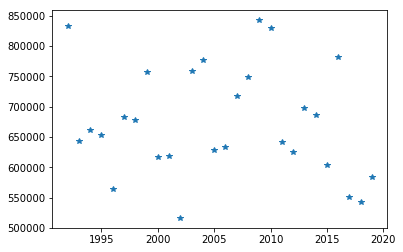

In [12]:
yearly_incidence.plot(style='*') 

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (à la fin).

In [13]:
yearly_incidence.sort_values() 

2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

Enfin, un histogramme montre bien que les épidémies fortes, qui touchent presque 1 million de français, sont assez rares.

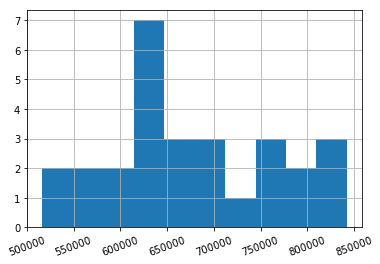

In [14]:
yearly_incidence.hist(xrot=20) 